In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import statsmodels.formula.api as smf
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import GridSearchCV as gs
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
# Load in data
train = pd.read_csv("Letters_train_2024.csv")
test = pd.read_csv("Letters_test_2024.csv")
# TODO: Load in data (after analyzing the dataset, delete any ouputs such as df.inf(), df.head(), et). 
# this cell should not output anything

# Question 1 (25 points)

In [3]:
# TODO: Create new variable here
train["isB"] = train["letter"].apply(lambda x: 1 if x == "B" else 0)
test["isB"] = test["letter"].apply(lambda x: 1 if x == "B" else 0)

In [4]:
# TODO: Split into X and y
Xtrain = train.drop(columns = "letter")
Xtest = test.drop(columns = "letter")

Ytrain = train["letter"]
Ytest = test["letter"]


### Part A: Baseline Model (3 points)

In [5]:
# Q1A code
# TODO: calcuate baseline accuracy
mode = Xtrain["isB"].mode()
#index into value counts of test in order to get accuracy % correct for testing given training mode prediction only.
sumMode =  Xtest["isB"].value_counts()[mode][0]
baseline_1_acc = sumMode / Ytest.shape[0]


print(f'Baseline Test Accuracy: {baseline_1_acc:.4f}')


Baseline Test Accuracy: 0.7497


### Part B: Logistic Regression (5 points)

In [6]:
# Q1B code
#assemble logit function based on all feature columns present in dataset.
model = smf.logit("isB ~ xbox+ ybox+ width+ height+ onpix+ xbar+ ybar+ x2bar+ y2bar+ xybar+ x2ybar+ xy2bar+ xedge+ xedgeycor+ yedge+ yedgexcor", data = Xtrain).fit(disp= False)

#predict our held out testing data
predictedProbs = model.predict(Xtest)

#adjust to binary based on 0.5 threshold
predicted_labels = [1 if prob >= 0.5 else 0 for prob in predictedProbs]
truthBinaryLogit = Ytest.apply(lambda x: 1 if x =="B" else 0)

# TODO: calcuate logistic accuracy accuracy, I used sklearn's accuracy_score to save the hastle of comparing arrays repeatedly.
model_1b_acc = accuracy_score(truthBinaryLogit, predicted_labels)
print("Logistic Regression Test Acc:", model_1b_acc)


Logistic Regression Test Acc: 0.9390374331550803


### Part C: AUC (2 point)

In [7]:
# Q1C code
truth_numeric = [1 if x == "B" else 0 for x in Ytest]
model_1b_auc = roc_auc_score(truth_numeric, predictedProbs) # TODO: Calculate logistic AUC
print(f'Logistic Regression Test AUC: {model_1b_auc:.4f}')

Logistic Regression Test AUC: 0.9764


### Part D: Cross-validated CART (5 points)

**Written Answer**: I iterated over the ccp alpha parameter using a dictionary passed into gridsearchCV, aliased as gs. Using numpys linspace function, i created an arra, which started at 0, stopped at 0.007, and sliced this range into 200 ccp_alphas to try, and using a 10 fold split to validate our hyperparameter candidates, which I think is are reasonable numbers. In my experience, alphas greater than 0.01 are not good values to use for your tree fitting, as it requires the removal of any leaf to cause less than ccp alpha gain in imurity score, and large values allow for lots of pruning, likely shrinking our tree too much. using a cv did not help my accuracy much, even moving it around to different values or leaving it out, I still get the same accuracies give or take .02%. Finally, because the object i save the gridsearch call to stores the best parameters it finds for the given estimator, I just fit this classifier object to my training data, and predict away, whcih is how i actually used the best ccp_alpha found.. The out of sample accuracy was 93.7%. 

In [8]:
# Q1D Code
#remove column isB, which we needed for smf logistic regression
trainFeatures, testFeatures = Xtrain.drop(columns = "isB"), Xtest.drop(columns = "isB")
trainLabels, testLabels = Xtrain["isB"], Xtest["isB"]

#search over this set of ccp_alphas for alpha with minimal error.
grid = {'ccp_alpha': np.linspace(0,0.007, 200)}
#declare classifier inside the gridSearch call, and search for best ccp_alpha out of the 200 options.
gridModel = gs(DTC(random_state = 2024), param_grid = grid, cv = 10).fit(trainFeatures, trainLabels)

#get Prediction array for all test observations, compare to test set target variables. proportion correct == accuracy for the model.
preds = gridModel.predict(testFeatures)
model_1d_acc = accuracy_score(testLabels,preds) # TODO: calculate best CV accuracy 
model_1d_best_ccp_alpha = round(gridModel.best_params_.get('ccp_alpha'), 5) # TODO: get best ccp_alpha

print('Best ccp_alpha: ', model_1d_best_ccp_alpha)
print(f"Random Forest Classifier Acc. : {model_1d_acc:.3f}")

Best ccp_alpha:  0.00084
Random Forest Classifier Acc. : 0.939


### Part E: Random Forest (5 points)


In [9]:
# Q1E Code
#fit the random forest classifier with default values for hyperparam, to the training data and giving it the labels as well.
rfc = RFC(random_state = 2024).fit(Xtrain.drop(columns = "isB"), Xtrain["isB"])

rfPreds = rfc.predict(testFeatures) #generate predictions according to fitted RF model.


# TODO: calculate random forest accuracy
model_1e_acc =  accuracy_score(testLabels, rfPreds)
print(f"Random Forest Classifier Acc. : {model_1e_acc:.3f}")


Random Forest Classifier Acc. : 0.971


### Part F: Performance Comparison (5 points)

The random forest slightly outperformed the other two. It had a ~97% accuracy with no finetuning hyperparameters whatsoever. I'd argue that because our model is not one that likely has to be routinely evaluated and updated like a healthcare model or ecommerce algorithm, I think interpretability doesnt matter AS much. Once we get a good English alphabet classifier, we will likely not need to change or therefore need to understand its parameters, implications, etc, as the english language is quite stagnant on the general level on any frequent basis. It can just be an abstract tool, and if it a good tool, we use it. Accuracy here though, is of the utmost importance, as misclassifying words on any semi frequent basis in important documents, important communication, or text crawling can have downstream effects on the end users and other personnel working with your results.

In [10]:
# Q1F Code
scores = pd.DataFrame({
    "Model Test Set Accuracy":  
     [f"Logistic Reg. Model Acc. : {model_1b_acc:.3f}",
    f"Decision Tree Classifier Acc. : {model_1d_acc:.3f}",
    f"Random Forest Classifier Acc. : {model_1e_acc:.3f}"]
})
scores
# TODO: create df to compare performance

,Model Test Set Accuracy
0,Logistic Reg. Model Acc. : 0.939
1,Decision Tree Classifier Acc. : 0.939
2,Random Forest Classifier Acc. : 0.971


***
# Question 2 (50 points)

In [11]:
# TODO: Redefine target y 
ldaLabelsTrain= train["letter"]
ldaLabelsTest = test["letter"]
#fixing datasets
ldaFeaturesTrain = train.drop(columns = ["letter", "isB"])
ldaFeaturesTest = test.drop(columns = ["letter", "isB"])


### Part A: Baseline Model (5 points)

In [12]:
# Q2A
#we want to predict mode of training data, and predict that for all observations regardless of x input.
modeTraining = ldaLabelsTrain.mode()[0]
#index into the valuecounts using our training mode, and we can get a very bad baseline accuracy!
baseline = ldaLabelsTest.value_counts()[modeTraining]

baseline_2_acc = baseline/ldaLabelsTest.shape[0]# TODO: calculate baseline accuracy
print(f'Baseline Test Accuracy: {baseline_2_acc:.4f}')

Baseline Test Accuracy: 0.2460


### Part B: LDA (8 points)

In [13]:
# Q2B code
# I simply fit the X matrix and target  y label vector to the LDA classifier, and without any fine tuning, this model was one of the worst out of the box.
lda = LDA().fit(ldaFeaturesTrain, ldaLabelsTrain)
#predict labels for all obs in test X matrix.
ldaPreds = lda.predict(ldaFeaturesTest)

model_2b_acc = accuracy_score(ldaLabelsTest, ldaPreds) # Calculate LDA accuracy
print(f'LDA Test Accuracy: {model_2b_acc:.4f}')

LDA Test Accuracy: 0.9123


### Part C: Cross-validated CART (10 points)

**Written Answer**: Once again, I set a numpy linspace at 0--> 0.007, taking 250 steps to get there, trying each alpha to see which performs best under the validation sets provided by cv =5, meaning 5 folded dataset stratefied. Using gridsearch and passing in a Decision tree classifier, by calling predict on this gridsearch estimator, it had automatically stored the best ccp_alpha that i iterated through and validated using 4 folds of the dataset. Once again, the cv parameter didnt really improve accuracy but maybe it found a somehwat "regularized" ccp_alpha. Looking at the accuracy on out of sample data, it was 92.3%.

In [14]:
# Q2C Code
#make same ccp alpha dictionary to search 
params_ccp = {"ccp_alpha": np.linspace(0,0.007, 250)}
#make gridTree, the classification tree with the best performing ccp_alpha, fitted to the same data as last q. 
gridTree = gs(DTC(random_state = 2024), param_grid = params_ccp, n_jobs = -1, cv = 4).fit(ldaFeaturesTrain, ldaLabelsTrain)
#predict using test set without Y label column.
ctmtPreds = gridTree.predict(ldaFeaturesTest)

model_2c_acc = accuracy_score(ldaLabelsTest, ctmtPreds)# TODO: calculate CV CART accuracy
print(f'CART Test Accuracy: {model_2c_acc:.4f}')

CART Test Accuracy: 0.9230


### Part D: Vanilla Bagging (8 points)

In [15]:
# Q2D
vbrForest = RFC(max_features = ldaFeaturesTrain.shape[1], random_state = 2024).fit(ldaFeaturesTrain, ldaLabelsTrain)
vanillaPreds = vbrForest.predict(ldaFeaturesTest)
model_2d_acc = accuracy_score(ldaLabelsTest, vanillaPreds) # TODO: Calculate vanilla bagging accuracy
print(f'No CV Random Forest Test Accuracy: {model_2d_acc:.4f}')

No CV Random Forest Test Accuracy: 0.9604


### Part E: Cross-validated Random Forest (10 points)

**Written Answer**: To execute gridsearch cv, I set the cross validation folds at 6, and using these mini partitions of the dataset, I iterated over all possible values for max_features, 1--> 16, as there are 16 columns in training data. Then once i made my cvrForest estimator containing the best hyperparameters found automatically by gridsearch which maximize the accuracy for the seen training folds and training set. The accuracy i achieved was 97.54% at 6 folds and trying [1:16] features. It found that the best max_feature was 2, as well.

In [16]:
# Q2E

feature_grid = {"max_features": np.arange(1,17)}
cvrForest = gs(RFC( random_state = 2024),param_grid = feature_grid, cv = 6, n_jobs = -1).fit(ldaFeaturesTrain, ldaLabelsTrain)
cvForestPreds = cvrForest.predict(ldaFeaturesTest)

# TODO: Calculate RF accuracy
model_2e_acc = accuracy_score(ldaLabelsTest, cvForestPreds)
print(f'CV Random Forest Test Accuracy: {model_2e_acc:.4f}')
print(cvrForest.best_params_)

CV Random Forest Test Accuracy: 0.9754
{'max_features': 2}


### Part F: Gradient Boosting Classifier (9 points)

In [17]:
# Q2F
#Fit the gradient boosting classifier to the same data we've been using.
gbc = GBC(n_estimators = 200, max_leaf_nodes = 10).fit(ldaFeaturesTrain, ldaLabelsTrain)
#predict using hyperparameters 200 estimators and 10 leaf node max , keeping tree size narrow and lengthy.
gbcPreds = gbc.predict(ldaFeaturesTest)
model_2f_acc = accuracy_score(ldaLabelsTest, gbcPreds)# Calculate boosting accuracy
print(f'GBC Test Accuracy: {model_2f_acc:.4f}')

GBC Test Accuracy: 0.9701


*** 

# Question 3 (25 points)

## Part A (6 points)

**Written Answer**: My two best models were Random forest classifier basic, and CV Random Forest classifier.

In [18]:
def performBootstrap(X,Y, model1, model2,nBootstrap) -> dict:
    dict = {}
     
    nSamples = X.shape[0]
    
    
    # Precompute the predictions for faster evaluations, and then just shuffle these.
    model1Predictions = model1.predict(X)
    model2Predictions = model2.predict(X)
    
    
    for k in range(nBootstrap): 
        #set deterministic randomness with seed being k.
        rng = np.random.default_rng(seed=k)
        bootstrapIndices = rng.integers(0, nSamples, size = nSamples)
        yBootstrap = Y[bootstrapIndices]
        
        #THIS IS FOR THE RFC MODEL, WHICH PREDICTS "isB" 1/0, not letter.  this transforms the letter distribution to a binary.
        yBootstrapBinary = np.where(yBootstrap == "B", 1, 0)
        
        # Compute accuracies for the bootstrap sample
        acc1 = accuracy_score(yBootstrap, model1Predictions[bootstrapIndices]) #for cvrforest
        acc2 = accuracy_score(yBootstrapBinary, model2Predictions[bootstrapIndices]) #for rfc
        
        dict[k] = [acc1, acc2]

    return dict
    """
    TODO: Complete the function to perform bootstrap.
    Function should return a dictionary of results from the bootstap. 
    We should be able to run your function exactly as is and reproduce the same results.
    Check random seed when sampling
    """    

In [19]:
# Q3A Code 
#Save call of accuracy distribution to "dict"
dict = performBootstrap(ldaFeaturesTest, ldaLabelsTest, cvrForest, rfc, 10000) 
print([dict[i] for i in range(5)]) #dictionary of 10,000 lists, only first five elements are printed here.
# TODO: Run bootstrap function above

[[0.9657754010695188, 0.9732620320855615], [0.9711229946524064, 0.9668449197860962], [0.9711229946524064, 0.9711229946524064], [0.9764705882352941, 0.9679144385026738], [0.9786096256684492, 0.9732620320855615]]


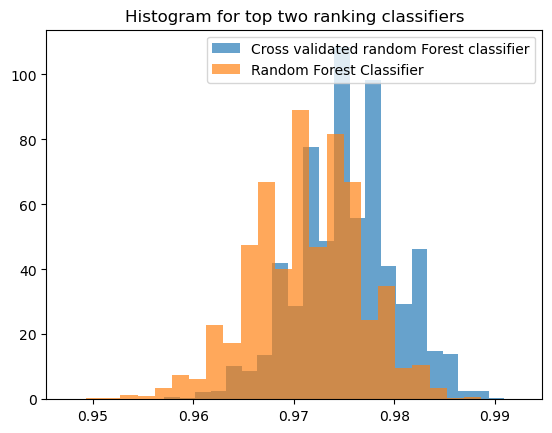

In [20]:
# Q3A Code 2
cvrArray = np.array([value[0] for value in dict.values()]) #first value of every list in the dictionary is going to by grouped with the other classifications its model made.
rfcArray = np.array([value[1] for value in dict.values()]) #this one for all rfc predictions.

#plot histogram showing density at each bin per classifier.
plt.hist(cvrArray, label = "Cross validated random Forest classifier", bins = 25, density = True,alpha = 0.68)
plt.hist(rfcArray, label = "Random Forest Classifier", bins = 25, density = True,alpha = 0.68)
plt.legend()
plt.title("Histogram for top two ranking classifiers")
plt.show()

# TODO: Print any plots, dataframes, analysis to support your answer

## Part B (6 points)

In [21]:
# Q3B
#get mean accuracy of both individual classifiers.
uc = np.mean(cvrArray)
ur = np.mean(rfcArray)

cse = 1.96*np.std(cvrArray)/100 #standard error for 95%CI, Z*sigma/sqrt(n)
rse = 1.96*np.std(rfcArray)/100

ci95forCvr = [uc - cse,uc +cse] #mean + / - standard error
ci95forRfc = [ur-rse, ur+rse] 


print("for cross-val RF:", ci95forCvr, "for basic RF:", ci95forRfc)

# TODO: print out the confidence interval

for cross-val RF: [0.9753124013379202, 0.9755102724588713] for basic RF: [0.971072312129202, 0.9712885434857712]


## Part C (6 points)

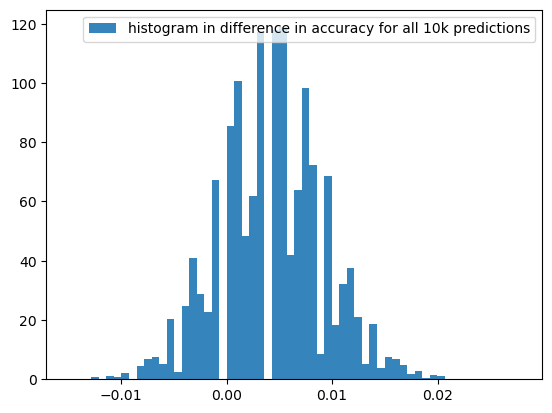

In [23]:
# Q3C
#TODO: Compute difference in accuracy
diff = cvrArray - rfcArray

#plotting histogram using difference in accuracy values. high bins makes large, sharp gaps appear.
plt.hist(diff, density = True, alpha = 0.9, bins = 60,label = "histogram in difference in accuracy for all 10k predictions")
plt.legend()
plt.show()



## Part D (7 points)

In [24]:
# Q3D
ud = np.mean(diff)
dse = 1.96*np.std(diff)/100
ci95diff = [ud-dse, ud+dse]
print("95% CI for the difference vector:", ci95diff)
#TODO: Compute 95% confidence interval

95% CI for the difference vector: [0.004132632528221717, 0.004329185653596468]


### Written Answer, Part D

In order to test a Null Hypothesis in a statistical setting, you first collect data, collect statistics on this data such as mean, quantity of data, and std, and you can establish a range of values where you'll be x% certain that the true parameter you are interested in falls between the lower and upper bounds, depending on your choice of z score. Given our 1.96 Z-score and hence 95% CI, and the fact that both the lower bound and upper bound are both positive, meaning the interval doesnt contain 0, we can reject the null hypothesis that "neither classifier is better than the other", and bet on a statistically significant difference between these two models,  because for a p-value at 0.05, we can be very confident that this relationship did not arise by random chance alone, but that our hypothesis is correct, that they are not quite equal after all. And so, we can go on our way using the statistically most likely model in order to predict our letters, the cross validated random forest..